In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture

In [3]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=1_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=50)

13.06.2022 03:16:43 Creating Training Directory at 2022-06-13_15-16_MinCut_CG_Classifier/
13.06.2022 03:16:43 Loading Datasets
13.06.2022 03:16:43 Start Training


Epoch 0: Training loss 11.4053; Validation loss 14.6862, MAE: 14.9327; lr: 0.00100
	Add. Loss: Training 0.2639, Validation 0.2452
Epoch 5: Training loss 4.1503; Validation loss 15.2723, MAE: 15.5300; lr: 0.00100
	Add. Loss: Training 0.2416, Validation 0.2388
Epoch 10: Training loss 3.3752; Validation loss 14.4291, MAE: 14.6909; lr: 0.00100
	Add. Loss: Training 0.2438, Validation 0.2288
Epoch 15: Training loss 2.8131; Validation loss 14.5422, MAE: 14.7989; lr: 0.00100
	Add. Loss: Training 0.2469, Validation 0.2358
Epoch 20: Training loss 2.3178; Validation loss 14.7011, MAE: 14.9610; lr: 0.00100
	Add. Loss: Training 0.2456, Validation 0.2289
Epoch 25: Training loss 2.2976; Validation loss 14.6333, MAE: 14.8909; lr: 0.00100
	Add. Loss: Training 0.2441, Validation 0.2296
Epoch 30: Training loss 2.0084; Validation loss 14.7389, MAE: 14.9907; lr: 0.00100
	Add. Loss: Training 0.2469, Validation 0.2344
Epoch 35: Training loss 1.6081; Validation loss 13.8300, MAE: 14.0724; lr: 0.00100
	Add. Lo

KeyboardInterrupt: 

In [10]:
#get training run data

run_dir = "run_data/2022-06-13_14-18_MinCut_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.2222 in epoch 4994
Minimum Validation Loss (after 50 epochs) 12.9361 in epoch 1763
Minimum MAE (after 50 epochs) 13.1801 in epoch 1763


Validation Loss at 1763 is 12.9361
5 before select
13.7332, 13.6231, 13.7497, 13.5319, 13.8135
5 after select
13.6557, 13.5788, 13.5708, 13.7423, 13.6457
MAE at 1763 is 13.1801


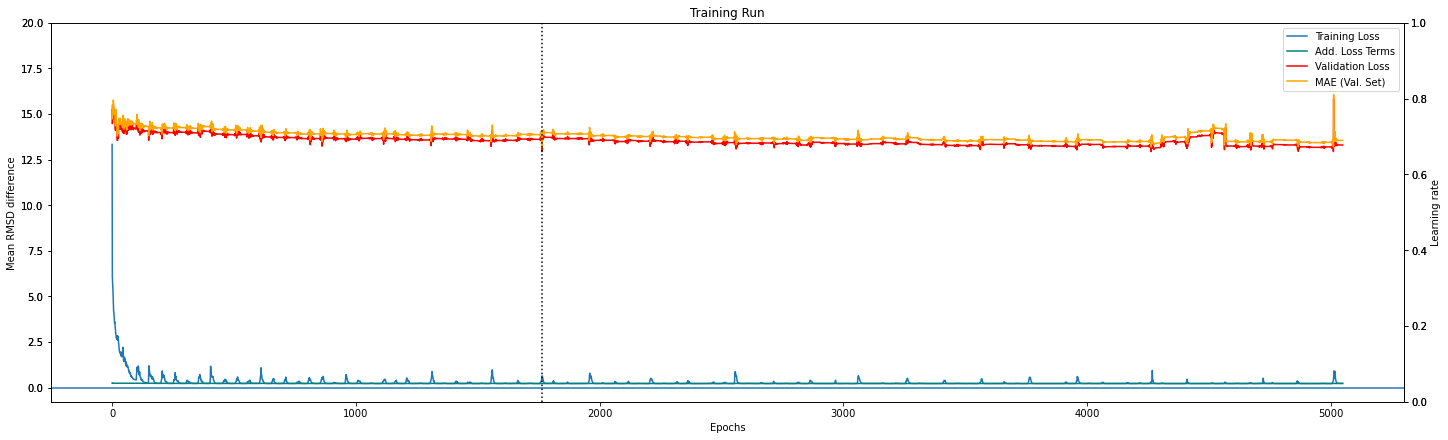

In [11]:
#plot the training run
select = 1763

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 1763
Test Set
Minimum Loss: Label = 21.7610, Prediction = 21.7344, Loss = 0.0004
Maximum Loss: Label = 0.0000, Prediction = 27.9176, Loss = 27.4176
Mean Test loss: 	 11.8790
Std. Dev. of Test loss:  7.5779
Min loss: 		 0.0004
First Quantile: 	 6.2739
Median: 		 10.5477
Third Quantile: 	 17.7645
Max Loss: 		 27.4176
LinregressResult(slope=-0.46555850302585494, intercept=25.967333777850236, rvalue=-0.17571181080166473, pvalue=0.0033455484009736903, stderr=0.15728848915388155, intercept_stderr=3.1815343527974447)


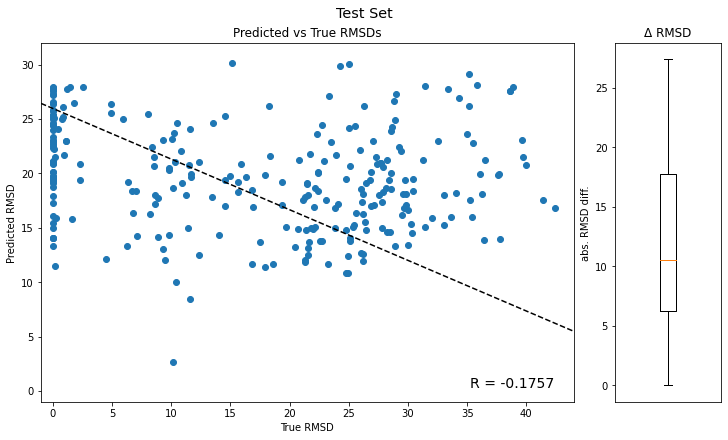

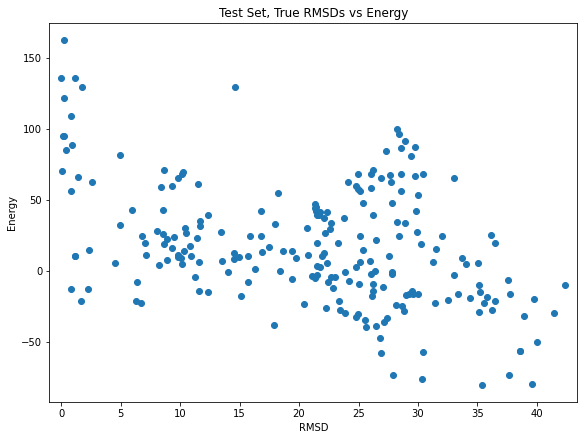

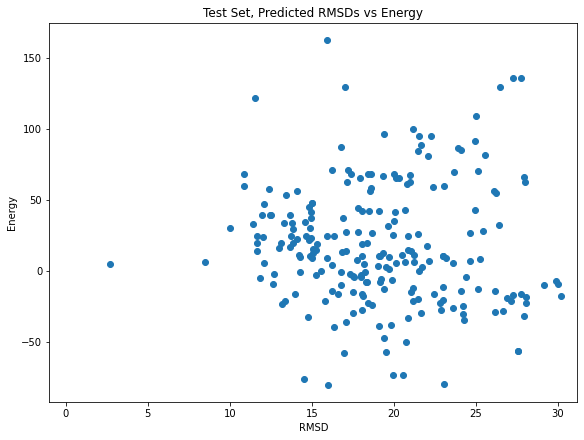

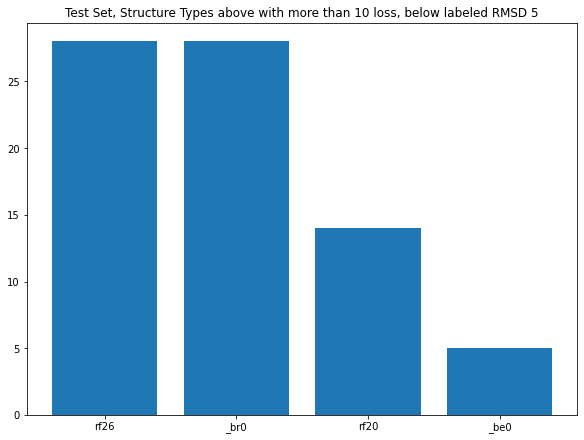

Prediction below 0: Label 0.0000, Pred -3.6783
Prediction below 0: Label 3.5120, Pred -2.7897
Prediction below 0: Label 0.0000, Pred -2.1650
5S and tRNA Test Set
Minimum Loss: Label = 19.5980, Prediction = 19.5951, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 26.1675, Loss = 25.6675
Mean Test loss: 	 3.8025
Std. Dev. of Test loss:  4.2793
Min loss: 		 0.0000
First Quantile: 	 0.8617
Median: 		 2.5008
Third Quantile: 	 5.2626
Max Loss: 		 25.6675
LinregressResult(slope=0.9256548140900718, intercept=-0.08102194842040511, rvalue=0.7515503524103175, pvalue=1.603013235229793e-197, stderr=0.024712042387609698, intercept_stderr=0.4625418171644175)


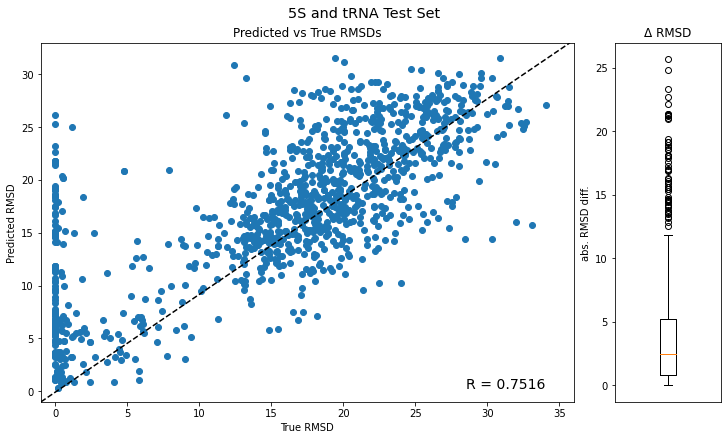

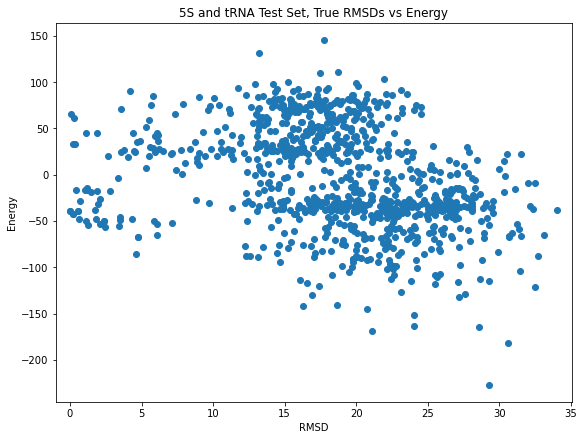

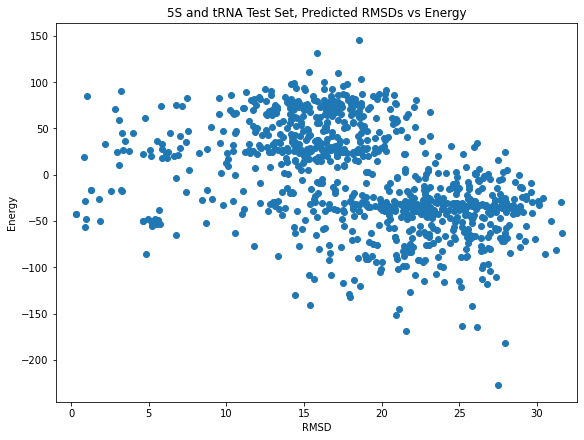

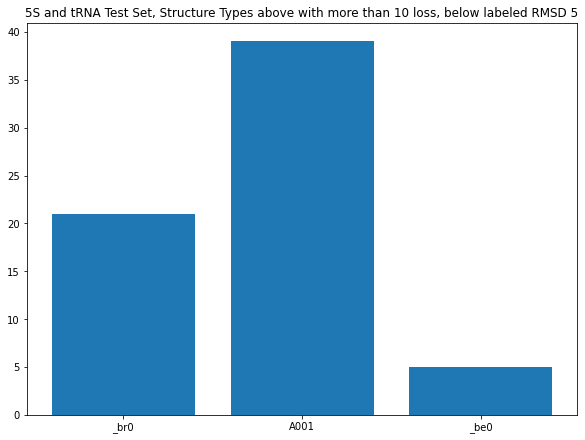

Prediction below 0: Label 0.0000, Pred -3.4802
Prediction below 0: Label 0.0330, Pred -0.0243
Prediction below 0: Label 0.0000, Pred -3.4802
Prediction below 0: Label 0.0340, Pred -0.0252
Training Set
Minimum Loss: Label = 30.8780, Prediction = 30.8789, Loss = 0.0000
Maximum Loss: Label = 2.9090, Prediction = 8.3515, Loss = 4.9425
Mean Test loss: 	 0.3714
Std. Dev. of Test loss:  0.6544
Min loss: 		 0.0000
First Quantile: 	 0.0233
Median: 		 0.1157
Third Quantile: 	 0.4074
Max Loss: 		 4.9425
LinregressResult(slope=1.0130140419031888, intercept=-0.03771981479970066, rvalue=0.9939988317222233, pvalue=0.0, stderr=0.004049256992465096, intercept_stderr=0.08044037359038543)


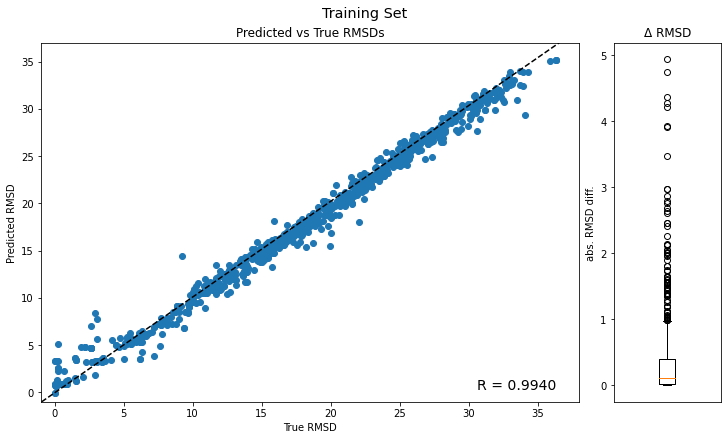

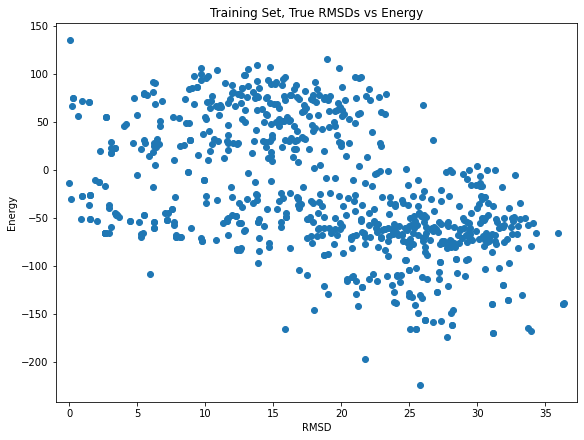

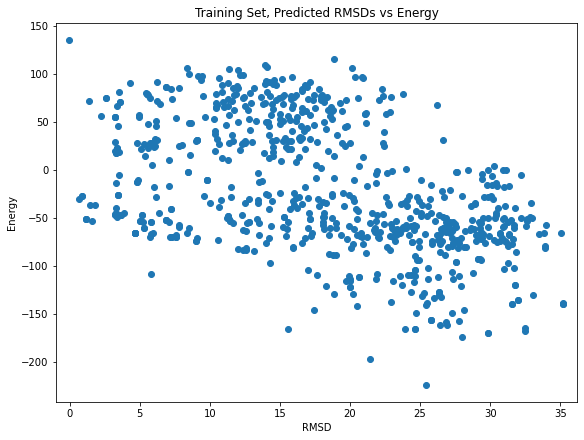

Validation Set
Minimum Loss: Label = 17.6730, Prediction = 17.6606, Loss = 0.0001
Maximum Loss: Label = 61.9850, Prediction = 18.2025, Loss = 43.2825
Mean Test loss: 	 12.6974
Std. Dev. of Test loss:  9.4520
Min loss: 		 0.0001
First Quantile: 	 3.8854
Median: 		 12.1629
Third Quantile: 	 19.0269
Max Loss: 		 43.2825
LinregressResult(slope=0.4766269721990083, intercept=13.227362875394807, rvalue=0.15062831023724368, pvalue=0.0026544660519448467, stderr=0.15759423218469834, intercept_stderr=3.4073575242883525)


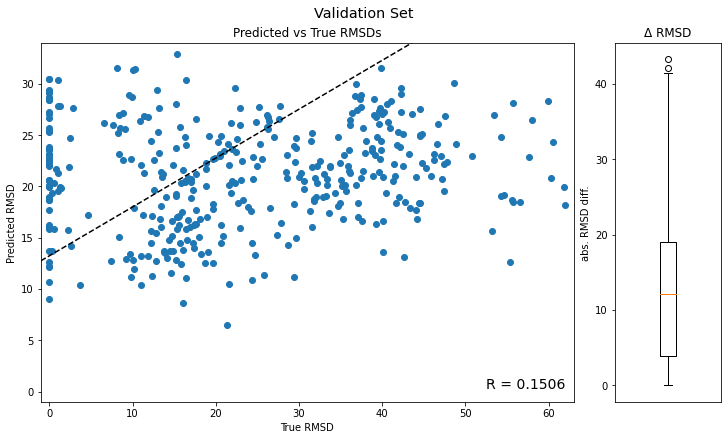

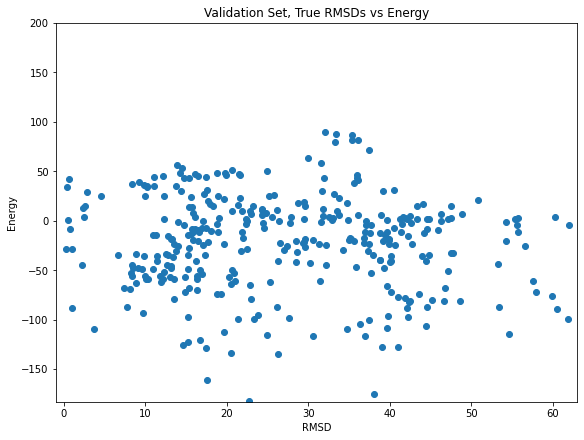

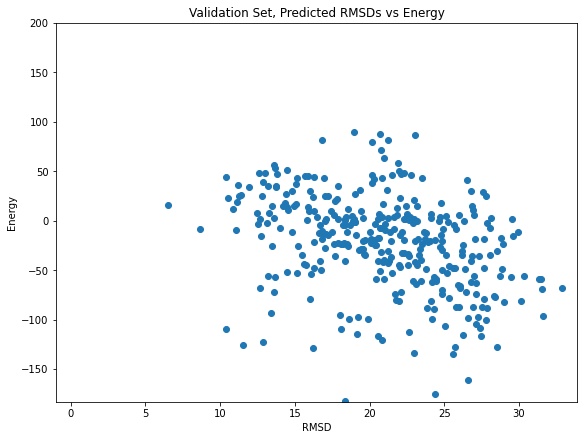

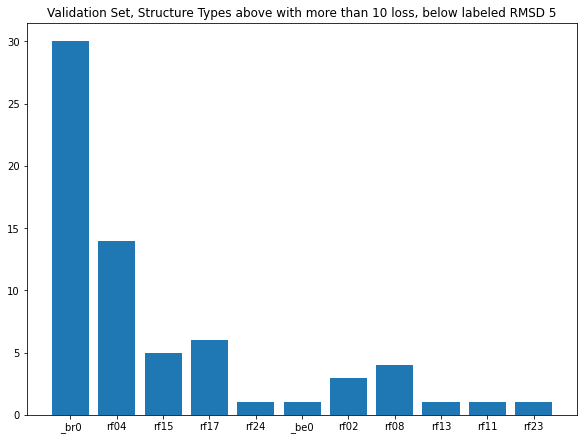

LinregressResult(slope=0.7270471120137655, intercept=6.816721354466454, rvalue=0.42873293951634095, pvalue=1.0227824011766378e-67, stderr=0.039703013694246635, intercept_stderr=0.8004222489079691)


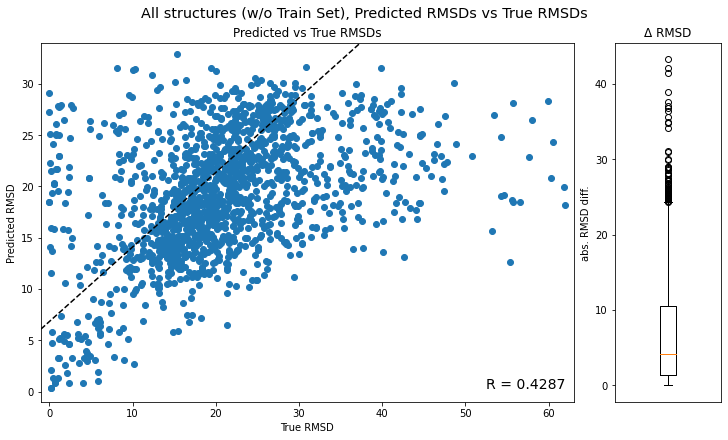

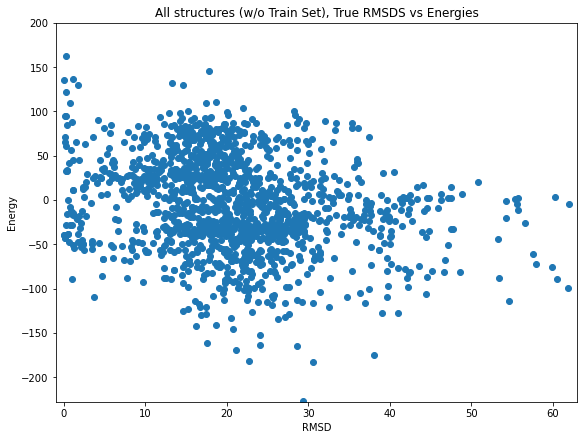

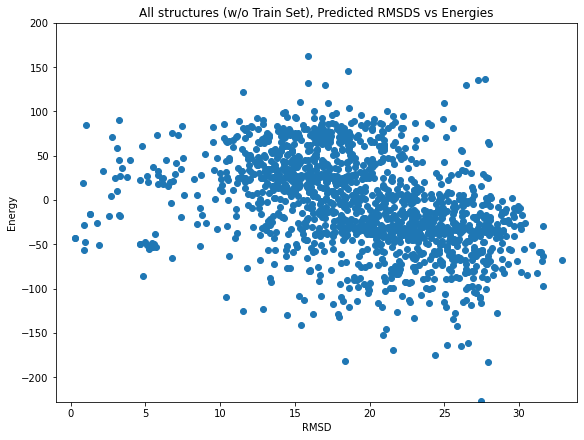

In [12]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=1.0028041508005343, intercept=-0.1448622544717857, rvalue=0.9786537215235469, pvalue=5.294515226000338e-191, stderr=0.012698917670314832, intercept_stderr=0.25745681513290664)


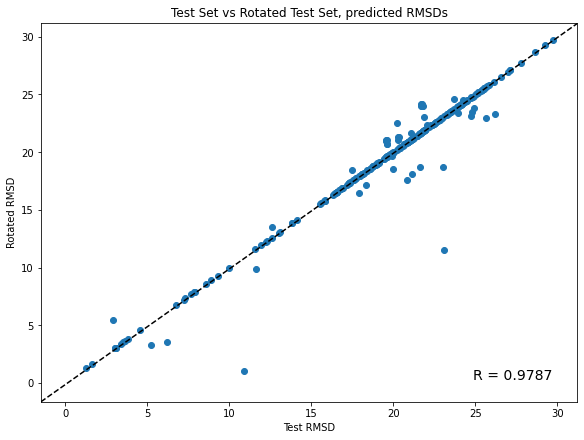

LinregressResult(slope=0.9887371526233785, intercept=0.03497527450104698, rvalue=0.9880382636716976, pvalue=2.613211198827996e-225, stderr=0.009305725225059349, intercept_stderr=0.124566404156903)


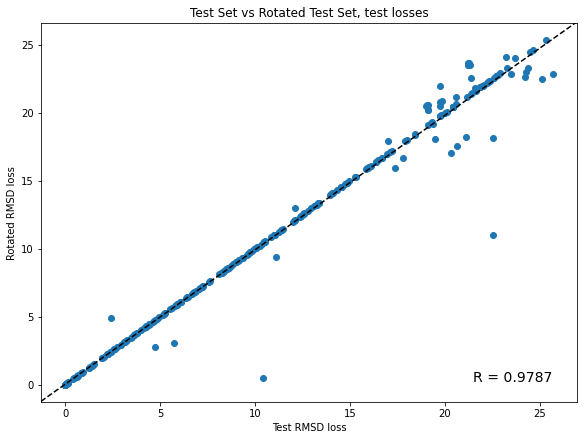

LinregressResult(slope=0.9471720243506062, intercept=1.0403823152746199, rvalue=0.9588585197040369, pvalue=0.0, stderr=0.00852909546986934, intercept_stderr=0.15978752980904776)


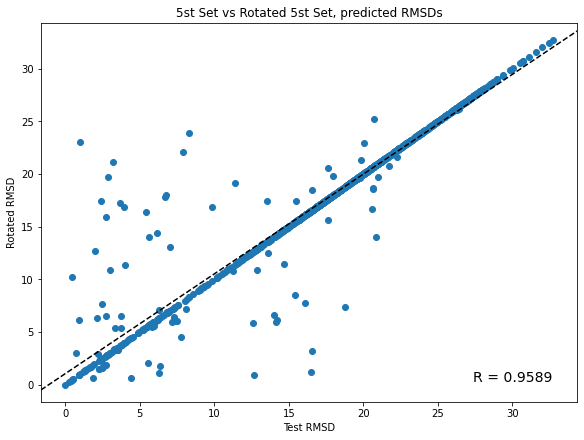

LinregressResult(slope=0.9395366526630656, intercept=0.3544965837011551, rvalue=0.891220447004958, pvalue=0.0, stderr=0.01454321587288265, intercept_stderr=0.08292381621815405)


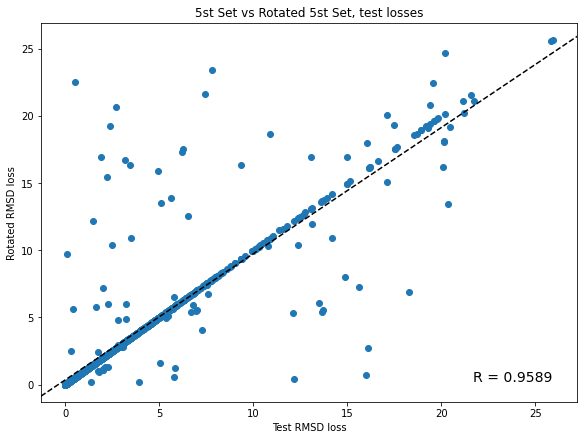

In [8]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")